In [4]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [9]:
features, true_labels = make_blobs(
    n_samples=200,
    centers=3,
    cluster_std=2.75,
    random_state=42
)

In [10]:
features[:5]

array([[  9.77075874,   3.27621022],
       [ -9.71349666,  11.27451802],
       [ -6.91330582,  -9.34755911],
       [-10.86185913, -10.75063497],
       [ -8.50038027,  -4.54370383]])

In [11]:
true_labels[:5]

array([1, 0, 2, 2, 2])

In [12]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [13]:
scaled_features[:5]

array([[ 2.13082109,  0.25604351],
       [-1.52698523,  1.41036744],
       [-1.00130152, -1.56583175],
       [-1.74256891, -1.76832509],
       [-1.29924521, -0.87253446]])

In [ ]:
kmeans = KMeans(
    init="random",          # par défaut kmeans utilise kmeans ++ maintenant, bien meilleur pour initialiser des points très distants pour rendre la convergence plus rapide en cluster
    n_clusters=3,           # paramètre le plus important le nombre de clusters
    n_init=10,              # nombre d'initalisations de l'algo kmeans
    max_iter=300,
    random_state=42
)

In [15]:
kmeans.fit(scaled_features)

,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",3
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'random'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",10
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",42
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


statistiques sur le meilleur kmeans meilleur SSE (sum of squared errors)

In [17]:
# The lowest SSE value
kmeans.inertia_


74.57960106819853

In [18]:
# Final locations of the centroid
kmeans.cluster_centers_


array([[ 1.19539276,  0.13158148],
       [-0.25813925,  1.05589975],
       [-0.91941183, -1.18551732]])

In [19]:
# The number of iterations required to converge
kmeans.n_iter_

10

In [20]:
kmeans.labels_[:5]

array([0, 1, 2, 2, 2], dtype=int32)

# elbow method pour le nombre de clusters

In [21]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

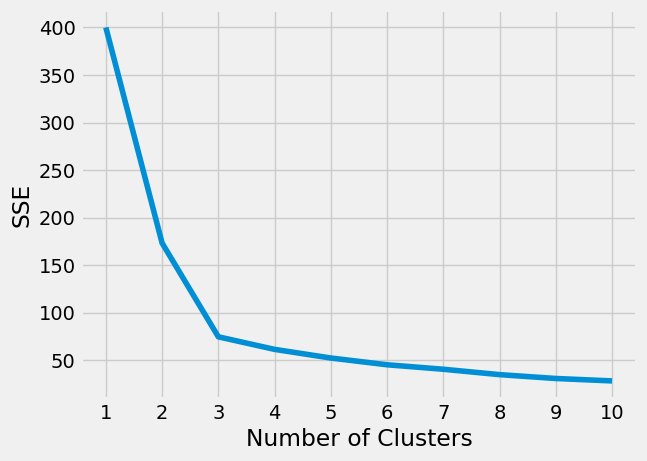

In [23]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

There’s a sweet spot where the SSE curve starts to bend known as the elbow point. The x-value of this point is thought to be a reasonable trade-off between error and number of clusters. In this example, the elbow is located at x=3:

ici elbow point evident 3

quand c'est moins evident, KneeLocator aide a identifier ce point elbow

In [24]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

np.int64(3)

# Silhouette

The silhouette coefficient is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors: <br>
How close the data point is to other points in the cluster <br>
How far away the data point is from points in other clusters

In [25]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

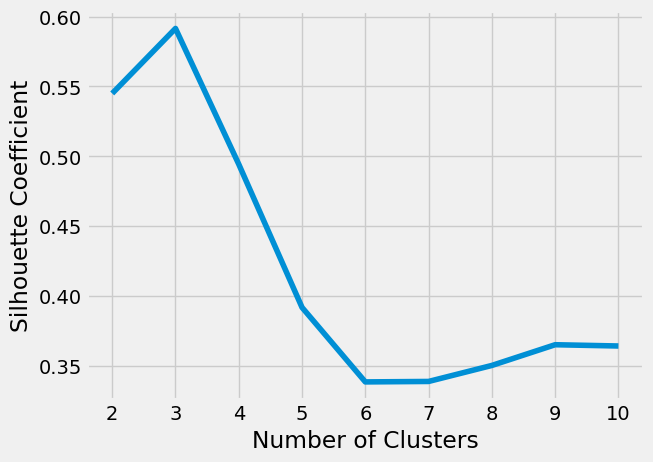

In [26]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Ultimately, your decision on the number of clusters to use should be guided by a combination of domain knowledge and clustering evaluation metrics.

In [27]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score

In [28]:
features, true_labels = make_moons(
    n_samples=250, noise=0.05, random_state=42
)
scaled_features = scaler.fit_transform(features)

In [32]:
# Instantiate k-means and dbscan algorithms
kmeans = KMeans(n_clusters=2)
dbscan = DBSCAN(eps=0.3)

# Fit the algorithms to the features
kmeans.fit(scaled_features)
dbscan.fit(scaled_features)

# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(
    scaled_features, kmeans.labels_
)
dbscan_silhouette = silhouette_score(
   scaled_features, dbscan.labels_
)

In [35]:
print(kmeans_silhouette)


print(dbscan_silhouette)

0.49664368674348447
0.3796684009045674


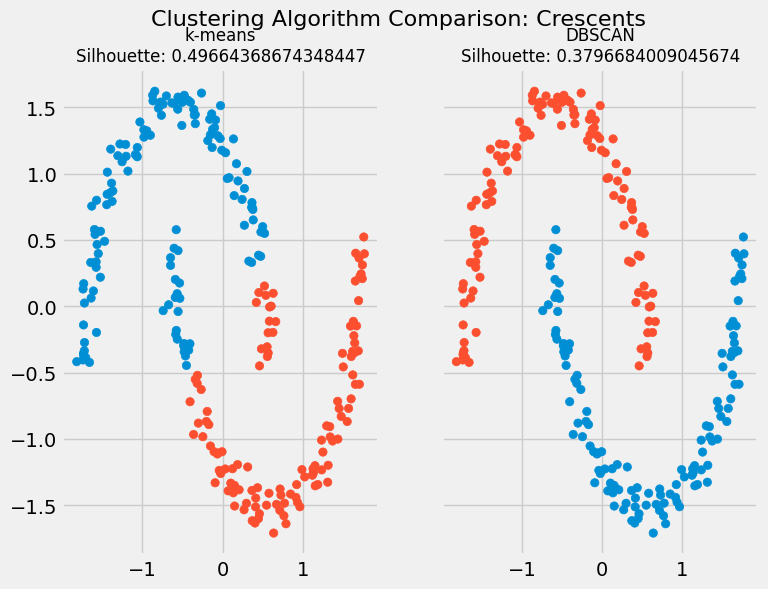

In [36]:
# Plot the data and cluster silhouette comparison
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(8, 6), sharex=True, sharey=True
)
fig.suptitle(f"Clustering Algorithm Comparison: Crescents", fontsize=16)
fte_colors = {
    0: "#008fd5",
    1: "#fc4f30",
}
# The k-means plot
km_colors = [fte_colors[label] for label in kmeans.labels_]
ax1.scatter(scaled_features[:, 0], scaled_features[:, 1], c=km_colors)
ax1.set_title(
    f"k-means\nSilhouette: {kmeans_silhouette}", fontdict={"fontsize": 12}
)

# The dbscan plot
db_colors = [fte_colors[label] for label in dbscan.labels_]
ax2.scatter(scaled_features[:, 0], scaled_features[:, 1], c=db_colors)
ax2.set_title(
    f"DBSCAN\nSilhouette: {dbscan_silhouette}", fontdict={"fontsize": 12}
)
plt.show()

The silhouette coefficient is higher for the k-means algorithm. The DBSCAN algorithm appears to find more natural clusters according to the shape of the data: <br>
This suggests that you need a better method to compare the performance of these two clustering algorithms.

ici on connait les ground truth label, on evalue les performances

In [39]:
ari_kmeans = adjusted_rand_score(true_labels, kmeans.labels_)
ari_dbscan = adjusted_rand_score(true_labels, dbscan.labels_)

print(f'kmeans : {round(ari_kmeans, 2)}')


print(f'dbscan :  {round(ari_dbscan, 2)}')

kmeans : 0.47
dbscan :  1.0


ari score between -1 and 1, 0 being random. Ici dbscan score parfait

# How to Build a K-Means Clustering Pipeline in Python

In [41]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pandas-3.0.0-cp314-cp314-win_amd64.whl.metadata (19 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached pandas-3.0.0-cp314-cp314-win_amd64.whl (9.9 MB)
Using cached tzdata-2025.3-py2.py3-none-any.whl (348 kB)

   ---------------------------------------- 0/3 [tzdata]
   ------------- -------------------------- 1/3 [pandas]
   ------------- -------------------------- 1/3 [pandas]
   ------------- -------------------------- 1/3 [pandas]
   ------------- -------------------------- 1/3 [pandas]
   ------------- -------------------------- 1/3 [pandas]
   ------------- -------------------------- 1/3 [pandas]
   ------------- -------------------------- 1/3 [pandas]
   ------------- -------------------------- 1/3 [pandas]
   ------------- -------------------------- 1/3 [pandas]
   ------------- -------------------------- 1/3 [pand

In [44]:
import tarfile
import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [45]:
uci_tcga_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

# Build the url
full_download_url = urllib.parse.urljoin(uci_tcga_url, archive_name)

# Download the file
r = urllib.request.urlretrieve (full_download_url, archive_name)

# Extract the data from the archive
tar = tarfile.open(archive_name, "r:gz")
tar.extractall()
tar.close()

In [46]:
datafile = "TCGA-PANCAN-HiSeq-801x20531/data.csv"
labels_file = "TCGA-PANCAN-HiSeq-801x20531/labels.csv"

data = np.genfromtxt(
    datafile,
    delimiter=",",
    usecols=range(1, 20532),
    skip_header=1
)

true_label_names = np.genfromtxt(
    labels_file,
    delimiter=",",
    usecols=(1,),
    skip_header=1,
    dtype="str"
)

Check out the first three columns of data for the first five samples as well as the labels for the first five samples:

In [55]:
data.shape

(801, 20531)

In [ ]:
print(data[:5, :3])

print(true_label_names[:5])

[[0.         2.01720929 3.26552691]
 [0.         0.59273209 1.58842082]
 [0.         3.51175898 4.32719872]
 [0.         3.66361787 4.50764878]
 [0.         2.65574107 2.82154696]]
['PRAD' 'LUAD' 'PRAD' 'PRAD' 'BRCA']


The data variable contains all the gene expression values from 20,531 genes. The true_label_names are the cancer types for each of the 881 samples. 

In [49]:
label_encoder = LabelEncoder()

true_labels = label_encoder.fit_transform(true_label_names)

true_labels[:5]

array([4, 3, 4, 4, 0])

In [ ]:
label_encoder.classes_

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype='<U4')

In [53]:
n_clusters = len(label_encoder.classes_)
n_clusters

5

on applique la réduction de dimensionnalité pca via pipeline

In [77]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

clustering pipeline incluant la pipeline de preprocessing

In [78]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)

pipeline globale

In [79]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [80]:
pipe.fit(data)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('clusterer', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('pca', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"feature_range feature_range: tuple (min, max), default=(0, 1)Desired range of transformed data.","(0, ...)"
,"copy copy: bool, default=TrueSet to False to perform inplace row normalization and avoid acopy (if the input is already a numpy array).",True
,"clip clip: bool, default=FalseSet to True to clip transformed values of held-out data topr

In [81]:
preprocessed_data = pipe["preprocessor"].transform(data)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)

0.5118775528450286

A silhouette coefficient of 0 indicates that clusters are significantly overlapping one another, and a silhouette coefficient of 1 indicates clusters are well-separated

In [82]:
adjusted_rand_score(true_labels, predicted_labels)

0.722276752060253

An ARI score of 0 indicates that cluster labels are randomly assigned, and an ARI score of 1 means that the true labels and predicted labels form identical clusters.

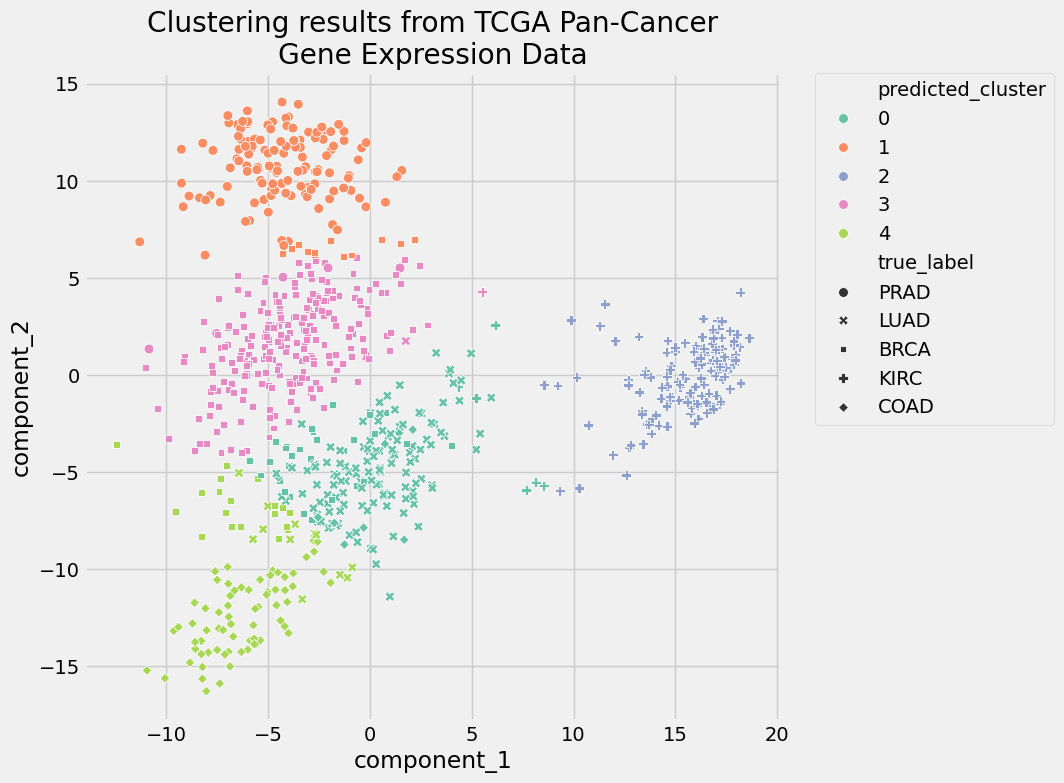

In [83]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(data),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    x= "component_1",
    y ="component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    style="true_label",
    palette="Set2",
)

scat.set_title(
    "Clustering results from TCGA Pan-Cancer\nGene Expression Data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

# Tuning a K-Means Clustering Pipeline

In [84]:
# Empty lists to hold evaluation metrics
silhouette_scores = []
ari_scores = []
for n in range(2, 11):
    # This set the number of components for pca,
    # but leaves other steps unchanged
    pipe["preprocessor"]["pca"].n_components = n
    pipe.fit(data)

    silhouette_coef = silhouette_score(
        pipe["preprocessor"].transform(data),
        pipe["clusterer"]["kmeans"].labels_,
    )
    ari = adjusted_rand_score(
        true_labels,
        pipe["clusterer"]["kmeans"].labels_,
    )

    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)
    ari_scores.append(ari)

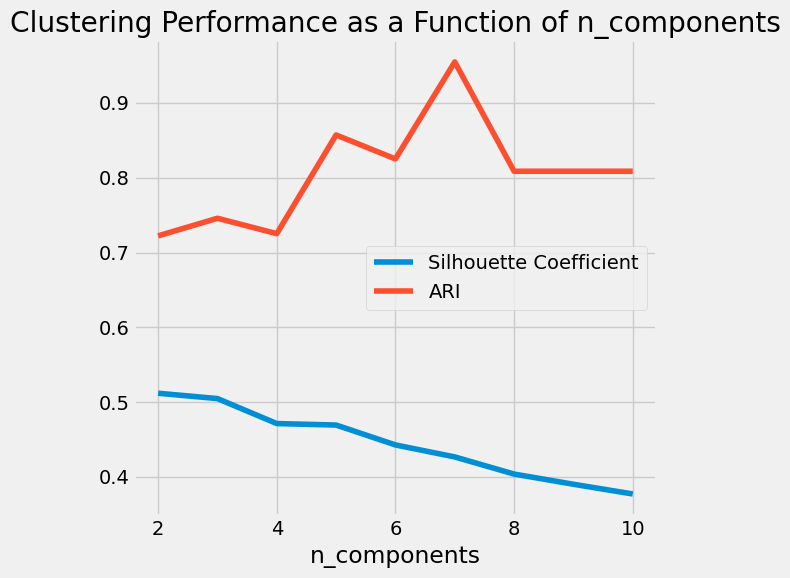

In [85]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(6, 6))
plt.plot(
    range(2, 11),
    silhouette_scores,
    c="#008fd5",
    label="Silhouette Coefficient",
)
plt.plot(range(2, 11), ari_scores, c="#fc4f30", label="ARI")

plt.xlabel("n_components")
plt.legend()
plt.title("Clustering Performance as a Function of n_components")
plt.tight_layout()
plt.show()

There are two takeaways from this figure: <br>

The silhouette coefficient decreases linearly. The silhouette coefficient depends on the distance between points, so as the number of dimensions increases, the sparsity increases. <br>

The ARI improves significantly as you add components. It appears to start tapering off after n_components=7, so that would be the value to use for presenting the best clustering results from this pipeline.

Like most machine learning decisions, you must balance optimizing clustering evaluation metrics with the goal of the clustering task. In situations when cluster labels are available, as is the case with the cancer dataset used in this tutorial, ARI is a reasonable choice. ARI quantifies how accurately your pipeline was able to reassign the cluster labels.